# Пример 1: обучение классификаторов на основе Moonshot

В этом примере мы показываем как обучать модель для классификации рентгенографических изображений грудной клетки на основе базовой модели Moonshot.

Для примера, мы обучаем и тестируем модель для классификации 27 различных патологий на датасете [VinDr-CXR dataset](https://vindr.ai/datasets/cxr) [1].

Чтобы продемонстрировать преимущество Moonshot по сравнению с другими моделями, мы сравниваем качество классификатора обученного на основе Moonshot, с качеством стандратного классификатора, обученного на основе ResNet50.

## 0. Установка и импорт зависимостей

Прежде чем начать, убедитесь, что вы установили все зависимости, следуя инструкции из [README](../README.md).

In [1]:
from typing import Optional, Literal, Callable, Sequence, Any
from pathlib import Path
from functools import partial
from multiprocessing import Pool
from tqdm.notebook import tqdm
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();
import pydicom
from PIL import Image
import cv2
cv2.setNumThreads(0);

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from torchmetrics.classification import (
    MultilabelAUROC, MultilabelAveragePrecision
)
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.utilities.types import OptimizerLRScheduler

from torchvision.models.resnet import resnet50

from moonshot.model import moonshot
from moonshot.image_processor import ImageProcessor
from moonshot.utils import eval_mode


DEVICE = torch.device('cuda')
NUM_WORKERS = 16  # поменяйте на кол-во доступных CPU

# укажите полный или относительный путь до файла с весами модели Moonshot
MOONSHOT_MODEL_FILEPATH = Path('../moonshot.pt')  # путь до модели, если она лежит в корне репозитория

## 1. Данные

### 1.1. Загрузка датасета

Загрузите датасет VinDr-CXR следуя инструкции на сайте [PhysioNet](https://physionet.org/content/vindr-cxr/1.0.0/).

После загрузки датасета, у вас на диске должна быть следующая папочная структура:
```
/path/to/vindr/
    - train
        - 000434271f63a053c4128a0ba6352c7f.dicom
        - 00053190460d56c53cc3e57321387478.dicom
        - 0005e8e3701dfb1dd93d53e2ff537b6e.dicom
        - ...
    - test
        - 002a34c58c5b758217ed1f584ccbcfe9.dicom
        - 004f33259ee4aef671c2b95d54e4be68.dicom
        - 008bdde2af2462e86fd373a445d0f4cd.dicom
        - ...
    - annotations
        - annotations_test.csv
        - annotations_train.csv
        - image_labels_test.csv
        - image_labels_train.csv
```


In [ ]:
# Раскомментируйте и укажите правильный путь до загруженного датасета
# VINDRCXR_DIRPATH = Path('/path/to/vindr')

### 1.2. Предварительный анализ данных

Давайте посмотрим на несколько случайных изображений из датасета:

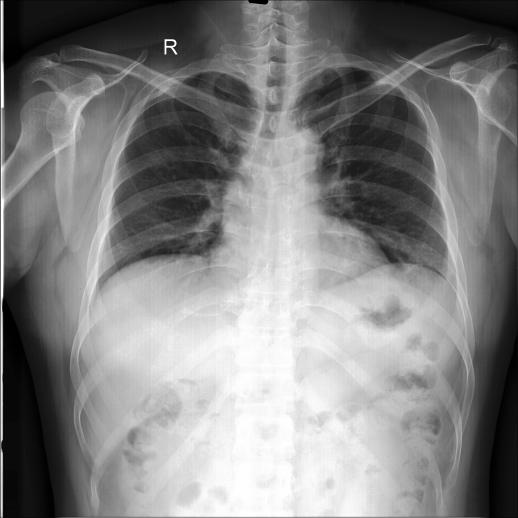

In [4]:
dicom_filepath = random.choice(list((VINDRCXR_DIRPATH / 'train').iterdir()))
dicom = pydicom.dcmread(dicom_filepath)
image = ImageProcessor.preprocess_dicom(dicom)
image.show()

Обратите внимание, что исходные изображения имеют очень высокое разрешение:

In [5]:
dicom.pixel_array.shape

(3072, 3072)

Посмотрим на таблицу с обучающими метками:

In [6]:
train_labels_df = pd.read_csv(VINDRCXR_DIRPATH / 'annotations' / 'image_labels_train.csv')
train_labels_df

,image_id,rad_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Clavicle fracture,Consolidation,Edema,Emphysema,...,Pneumothorax,Pulmonary fibrosis,Rib fracture,Other lesion,COPD,Lung tumor,Pneumonia,Tuberculosis,Other diseases,No finding
0,000434271f63a053c4128a0ba6352c7f,R2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,000434271f63a053c4128a0ba6352c7f,R3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,000434271f63a053c4128a0ba6352c7f,R6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,00053190460d56c53cc3e57321387478,R11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,00053190460d56c53cc3e57321387478,R2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,fff0f82159f9083f3dd1f8967fc54f6a,R8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
44996,fff0f82159f9083f3dd1f8967fc54f6a,R9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
44997,fff2025e3c1d6970a8a6ee0404ac6940,R1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
44998,fff2025e3c1d6970a8a6ee0404ac6940,R2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Обратите внимание, что в ней есть по три строки на каждое изображение. Это значит, что каждое изображение было размечено тремя врачами-рентгенологами.

Для обучения мы будем использовать метки, полученные голосованием:

In [7]:
# aggregate labels for each image by majority voting across multiple annotations
train_labels_df_agg = train_labels_df.drop('rad_id', axis=1).groupby('image_id').mean() > 0.5
train_labels_df_agg

,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Clavicle fracture,Consolidation,Edema,Emphysema,Enlarged PA,ILD,...,Pneumothorax,Pulmonary fibrosis,Rib fracture,Other lesion,COPD,Lung tumor,Pneumonia,Tuberculosis,Other diseases,No finding
image_id,,,,,,,,,,,,,,,,,,,,,
000434271f63a053c4128a0ba6352c7f,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
00053190460d56c53cc3e57321387478,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
0005e8e3701dfb1dd93d53e2ff537b6e,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False
0006e0a85696f6bb578e84fafa9a5607,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
0007d316f756b3fa0baea2ff514ce945,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe6f9fe648a7ec29a50feb92d6c15a4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
ffea246f04196af602c7dc123e5e48fc,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
ffeffc54594debf3716d6fcd2402a99f,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


Обратите внимание на то, что на одном изображении может быть выявлено больше одной патологии:

In [8]:
train_labels_df_agg.sum(axis=1) > 1

image_id
000434271f63a053c4128a0ba6352c7f    False
00053190460d56c53cc3e57321387478    False
0005e8e3701dfb1dd93d53e2ff537b6e     True
0006e0a85696f6bb578e84fafa9a5607    False
0007d316f756b3fa0baea2ff514ce945     True
                                    ...  
ffe6f9fe648a7ec29a50feb92d6c15a4     True
ffea246f04196af602c7dc123e5e48fc    False
ffeffc54594debf3716d6fcd2402a99f     True
fff0f82159f9083f3dd1f8967fc54f6a    False
fff2025e3c1d6970a8a6ee0404ac6940    False
Length: 15000, dtype: bool

Другими словами, патологи не являются взаимоисключающими, поэтому для каждой патологии мы будем обучать отдельный бинарный классификатор.

Оценим встречаемость каждой патологии на тренировочной выборке:

In [9]:
# estimate prevalences
prevalences = train_labels_df_agg.mean(axis=0)
prevalences

Aortic enlargement    0.156400
Atelectasis           0.004133
Calcification         0.011800
Cardiomegaly          0.121133
Clavicle fracture     0.000067
Consolidation         0.008067
Edema                 0.000067
Emphysema             0.000933
Enlarged PA           0.001400
ILD                   0.010133
Infiltration          0.016333
Lung Opacity          0.036467
Lung cavity           0.001333
Lung cyst             0.000267
Mediastinal shift     0.005667
Nodule/Mass           0.027267
Pleural effusion      0.042267
Pleural thickening    0.058800
Pneumothorax          0.003867
Pulmonary fibrosis    0.067800
Rib fracture          0.002733
Other lesion          0.024133
COPD                  0.000467
Lung tumor            0.008933
Pneumonia             0.031400
Tuberculosis          0.032133
Other diseases        0.266867
No finding            0.706733
dtype: float64

Мы видим, что большая часть патологий встречается довольно редко.

В условиях несбалансированности классов, в качестве лосс-функции для обучения модели обычно используют взвешенную бинарную кросс-энтропию. Согласно [документации](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) `torch.nn.BCEWithLogitsLoss`:

> For example, if a dataset contains $100$ positive and $300$ negative examples of a single class, then `pos_weight` for the class should be equal to $\frac{300}{100} = 3$.

Давайте подсчитаем эти веса для каждой патологии:

In [10]:
LABELS = list(train_labels_df_agg.columns)
POS_WEIGHTS = list((1 - prevalences) / prevalences)

Теперь давайте посмотрим на таблицу с тестовыми метками:

In [11]:
test_labels_df = pd.read_csv(VINDRCXR_DIRPATH / 'annotations' / 'image_labels_test.csv')
test_labels_df

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Clavicle fracture,Consolidation,Edema,Emphysema,Enlarged PA,...,Pneumothorax,Pulmonary fibrosis,Rib fracture,Other lesion,COPD,Lung tumor,Pneumonia,Tuberculosis,Other disease,No finding
0,e0dc2e79105ad93532484e956ef8a71a,0,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
1,0aed23e64ebdea798486056b4f174424,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,aa15cfcfca7605465ca0513902738b95,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,665c4a6d2693dc0286d65ab479c9b169,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,42da2c134b53cb5594774d3d29faac59,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,a039af299f86007d0d77da077a6def9a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2996,aba3d1f5b1c04236f52a8980929b2cfa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2997,6d3d6b53f358a983b486e9e03144eb62,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2998,d6678cb7ae39f575d35ab9da6d7cb171,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Обратите внимание, что в тестовой таблице на каждое изображение приходится только одна разметка.

Также обратите внимание, что в тестовой выборке нет ни одного положительного примера для патологии `Edema`:

In [12]:
test_labels_df.rename(columns={'Other disease': 'Other diseases'})[LABELS].any(axis=0)

Aortic enlargement     True
Atelectasis            True
Calcification          True
Cardiomegaly           True
Clavicle fracture      True
Consolidation          True
Edema                 False
Emphysema              True
Enlarged PA            True
ILD                    True
Infiltration           True
Lung Opacity           True
Lung cavity            True
Lung cyst              True
Mediastinal shift      True
Nodule/Mass            True
Pleural effusion       True
Pleural thickening     True
Pneumothorax           True
Pulmonary fibrosis     True
Rib fracture           True
Other lesion           True
COPD                   True
Lung tumor             True
Pneumonia              True
Tuberculosis           True
Other diseases         True
No finding             True
dtype: bool

Из-за этого мы не можем посчитать AUROC для этой патологии и не обучаем для нее классификатор:

In [13]:
POS_WEIGHTS.pop(LABELS.index('Edema'))
LABELS.remove('Edema')

### 1.3. Предобработка изображений


Как было замечено выше, исходные изображения имеют очень высокое разрешение. Для того чтобы подгрузка и предобработка изображений не занимала много времени в течение обучения, мы предобрабатываем их заранее и сохраняем на диск в меньшем разрешении, в формате PNG:

In [14]:
def preprocess_image(image_id: str, split: Literal['train', 'test']) -> None:
    dicom_filepath = VINDRCXR_DIRPATH / split / f'{image_id}.dicom'
    png_filepath = VINDRCXR_DIRPATH / f'{split}_png' / f'{image_id}.png'
    if png_filepath.exists():
        return

    dicom = pydicom.dcmread(dicom_filepath)
    image = ImageProcessor.preprocess_dicom(dicom)
    image.save(png_filepath)


preprocess_train_image = partial(preprocess_image, split='train')
train_image_ids = [image_filepath.name[:-len('.dicom')] for image_filepath in (VINDRCXR_DIRPATH / 'train').iterdir()]
(VINDRCXR_DIRPATH / 'train_png').mkdir(exist_ok=True)
with Pool(NUM_WORKERS) as p:
    _ = list(tqdm(p.imap(preprocess_train_image, train_image_ids), total=len(train_image_ids)))


preprocess_test_image = partial(preprocess_image, split='test')
test_image_ids = [image_filepath.name[:-len('.dicom')] for image_filepath in (VINDRCXR_DIRPATH / 'test').iterdir()]
(VINDRCXR_DIRPATH / 'test_png').mkdir(exist_ok=True)
with Pool(NUM_WORKERS) as p:
    _ = list(tqdm(p.imap(preprocess_test_image, test_image_ids), total=len(test_image_ids)))


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

### 1.4. Интерфейсы для подгрузки данных

Мы имплементируем стандартные классы основанные на `torch.utils.data.Dataset` и `lightning.pytorch.Datamodule` для подгрузки данных во время обучения и валидации.

Класс `torch.utils.data.Dataset` отвечает за подгрузку, препроцессинг и аугментации одиночных примеров:
 

In [15]:
class VINDRCXRDataset(Dataset):
    def __init__(
            self,
            vindrcxr_dirpath: str | Path,
            split: Literal['train', 'test'],
            image_transform: Callable[[Image], torch.Tensor]
    ) -> None:
        super().__init__()

        vindrcxr_dirpath = Path(vindrcxr_dirpath)

        if split == 'train':
            images_dirpath = vindrcxr_dirpath / 'train_png'
            labels_df = pd.read_csv(vindrcxr_dirpath / 'annotations' / 'image_labels_train.csv')
        elif split == 'test':
            images_dirpath = Path(vindrcxr_dirpath / 'test_png')
            labels_df = pd.read_csv(vindrcxr_dirpath / 'annotations' / 'image_labels_test.csv')
            labels_df = labels_df.rename(columns={'Other disease': 'Other diseases'})
        else:
            raise ValueError(split)

        self.images_dirpath = images_dirpath
        self.labels_df = labels_df
        self.ids = sorted(set(labels_df.image_id))
        self.split = split
        self.image_transform = image_transform

    def __len__(self) -> int:
        return len(self.ids)

    def __getitem__(self, index: int) -> Any:
        image_id = self.ids[index]

        image_filepath = self.images_dirpath / f'{image_id}.png'
        image = Image.open(image_filepath)
        image = self.image_transform(image)

        rows = self.labels_df[self.labels_df.image_id == image_id]
        # majority voting
        labels = np.array(rows[LABELS].mean(axis=0) > 0.5, dtype='int64')
        labels = torch.from_numpy(labels)

        return {
            'image': image,
            'labels': labels
        }


class TrainImageTransform:
    def __init__(self) -> None:
        self.transform = A.Compose([
            A.ToFloat(max_value=255.),
            A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0.0),
            A.RandomResizedCrop(size=ImageProcessor.image_size, scale=(0.5625, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
            A.Normalize(mean=ImageProcessor.image_mean, std=ImageProcessor.image_std, max_pixel_value=1.0),
            A.ToRGB(),
            ToTensorV2(transpose_mask=True)
        ])

    def __call__(self, image: Image) -> torch.Tensor:
        return self.transform(image=np.array(image))['image']


class TestImageTransform:
    def __init__(self) -> None:
        self.image_processor = ImageProcessor()

    def __call__(self, image: Image) -> torch.Tensor:
        return self.image_processor(image).squeeze(0)

Класс `lightning.pytorch.Datamodule` инкапсулирует логику разбиения датасета на обучающую и тестовую выборки и объекты типа `torch.utils.data.DataLoader`, которые отвечают за подгрузку батчей для обучения и валидации:

In [16]:
class VinDrCXRDataModule(pl.LightningDataModule):
    def __init__(
            self,
            vindrcxr_dirpath: str | Path,
            train_image_transform: Callable[[Image], torch.Tensor],
            test_image_transform: Callable[[Image], torch.Tensor],
            batch_size: int = 96,
            num_workers: int = 0,
            pin_memory: bool = True,
    ) -> None:
        super().__init__()

        self.vindrcxr_dirpath = vindrcxr_dirpath
        self.train_image_transform = train_image_transform
        self.test_image_transform = test_image_transform
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

    def prepare_data(self) -> None:
        """Этот метод обычно используется для загрузки и подготовки датасета на диске.
        Но мы уже скачали и предобработали датасет.
        """
        pass

    def setup(self, stage: Optional[str] = None) -> None:
        self.train_dataset = VINDRCXRDataset(
            vindrcxr_dirpath=self.vindrcxr_dirpath,
            split='train',
            image_transform=self.train_image_transform
        )
        self.val_dataset = self.test_dataset = VINDRCXRDataset(
            vindrcxr_dirpath=self.vindrcxr_dirpath,
            split='test',
            image_transform=self.test_image_transform,
        )
    
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        )


Давайте посмотрим как это работает:

In [17]:
datamodule = VinDrCXRDataModule(
    vindrcxr_dirpath=VINDRCXR_DIRPATH,
    train_image_transform=TrainImageTransform(),
    test_image_transform=TestImageTransform(),
    batch_size=4,
)
datamodule.prepare_data()
datamodule.setup()

for batch in datamodule.train_dataloader():
    break

print('Images:', batch['image'].shape)
print('Labels:', batch['labels'].shape)

Images: torch.Size([4, 3, 518, 518])
Labels: torch.Size([4, 27])


## 2. Модели

Для того, чтобы продемонстрировать преимущество Moonshot по сравнению с другими моделями, мы имплементируем две модели:  

1. Классификатор на основе стандартного предобученного энкодера ResNet50.

2. Классификатор на основе энкодера Moonshot.

### 2.1. Энкодеры

Энкодер - это основная часть нейросети, которая "кодирует" входное изображение в векторное представление. Затем, векторное представление подается на вход нескольким линейным классификаторам, которые предсказывают вероятности наличия патологий.

Мы имплементируем однообразный интерфейс для двух энкодеров: Moonshot и ResNet50, чтобы затем сравнить классификаторы обученные на их основе:

In [18]:
class ResNet50Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = resnet50(pretrained=True)
        self.model.fc = nn.Identity()  # удаляем классификационную голову
    
    def forward(self, image: torch.Tensor) -> torch.Tensor:
        return self.model(image)

    @property
    def out_dim(self) -> int:
        return 2048


class MoonshotEncoder(nn.Module):
    def __init__(self,) -> None:
        super().__init__()

        self.model = moonshot(model_filepath=MOONSHOT_MODEL_FILEPATH)

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        features = self.model.forward_features(image)
        pooled_features = self.model.forward_head(features, pre_logits=True)
        return pooled_features

    @property
    def out_dim(self) -> int:
        return 1024


### 2.2. Lightning module

Теперь мы имплементируем класс `lightning.pytorch.LightningModule`, который инкапсулирует всю логику обучения классификаторов, на основе данного энкодера.

In [19]:
class MultilabelClassification(pl.LightningModule):
    def __init__(
            self,
            encoder: nn.Module,
            num_labels: int,
            pos_weights: Optional[Sequence[float]] = None,
            freeze_until_epoch: Optional[int] = None,
            lr: float = 5e-5,
            label_names: Optional[Sequence[str]] = None,
    ) -> None:
        """Класс-наследник lightning.pytorch.LightningModule для классификации.

        Args:
            encoder (nn.Module):
                Предобученный энкодер, который получает на вход изображение, и выдает эмбеддинг.
            num_labels (int):
                Количество меток, для которых мы обучаем бинарные классификаторы (в нашем случае метка - это патология).
            pos_weights (Optional[Sequence[float]], optional):
                Веса во взвешенной кросс-энтропии для каждого бинарного классификатора.
            freeze_until_epoch (Optional[Union[int, float]], optional):
                В течение первых `freeze_until_epoch` энкодер остается замороженным.
                По умолчанию (`freeze_until_epoch=None`) энкодер размораживается с самой первой эпохи.
                Если передать `freeze_until_epoch=float('inf')` энкодер будет заморожен в течение всего обучения.
            lr (float, optional):
                Learning rate.
            label_names (Optional[Sequence[str]], optional):
                Названия меток (в нашем случае 'Lung Opacity', 'Cardiomegaly', и т.д.), используются для логгирования.
        """
        super().__init__()

        self.save_hyperparameters(ignore='encoder')

        self.encoder = encoder
        self.head = nn.Linear(encoder.out_dim, num_labels)
        self.pos_weights = pos_weights
        if label_names is not None:
            self.label_names = label_names
        else:
            self.label_names = [f'label_{i}' for i in range(num_labels)]
        self.metrics = nn.ModuleDict({
            'auroc': MultilabelAUROC(num_labels, average='none', ignore_index=-1),
            'ap': MultilabelAveragePrecision(num_labels, average='none', ignore_index=-1)
        })
        self.freeze_until_epoch = freeze_until_epoch
        self.lr = lr

    def training_step(self, batch: Any, batch_idx: int) -> torch.Tensor:
        image = batch['image']
        if self.freeze_until_epoch is not None and self.current_epoch < self.freeze_until_epoch:
            with torch.inference_mode(), eval_mode(self.encoder):
                features = self.encoder(image)
            features = features.clone()
        else:
            features = self.encoder(image)
        pred_logits = self.head(features)
        gt_labels = batch['labels'].to(self.dtype)

        if self.pos_weights is not None:
            pos_weights = torch.tensor(self.pos_weights, dtype=self.dtype, device=self.device)
            pos_weights = torch.broadcast_to(pos_weights, gt_labels.shape)
        else:
            pos_weights = torch.ones_like(gt_labels)
        loss = F.binary_cross_entropy_with_logits(pred_logits, gt_labels, pos_weight=pos_weights)
        self.log(f'train/loss', loss, prog_bar=True, on_epoch=True, on_step=False)

        return loss

    def on_validation_epoch_start(self) -> None:
        for metric in self.metrics.values():
            metric.reset()

    def validation_step(self, batch: Any, batch_idx: int) -> None:
        image = batch['image']
        features = self.encoder(image)
        pred_probs = torch.sigmoid(self.head(features))

        gt_labels = batch['labels']
        for metric in self.metrics.values():
            metric.update(pred_probs, gt_labels)

    def on_validation_epoch_end(self) -> None:
        for metric_name, metric in self.metrics.items():
            metric_values = metric.compute()
            for i, label_name in enumerate(self.label_names):
                self.log(f'val/{label_name}_{metric_name}', metric_values[i], prog_bar=True)
            self.log(f'val/avg_{metric_name}', metric_values.mean(), prog_bar=True)

    def configure_optimizers(self) -> OptimizerLRScheduler:
        optimizer = torch.optim.AdamW(
            params=self.parameters(),
            lr=self.lr
        )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            max_lr=self.lr,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.1,
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step',
            }
        }


## 3. Обучение классификаторов

Теперь мы используем реализованные классы `VinDrCXRDataModule` и `MultilabelClassification` для обучения и валидации классификаторов на основе `ResNet50Encoder` и `MoonshotEncoder`.

### 3.1. ResNet50

In [20]:
datamodule = VinDrCXRDataModule(
    vindrcxr_dirpath=VINDRCXR_DIRPATH,
    train_image_transform=TrainImageTransform(),
    test_image_transform=TestImageTransform(),
    batch_size=16,
    num_workers=NUM_WORKERS,
)
datamodule.prepare_data()
datamodule.setup()

model = MultilabelClassification(
    encoder=ResNet50Encoder(),
    num_labels=len(LABELS),
    pos_weights=POS_WEIGHTS,
    lr=5e-5,
    label_names=LABELS
)

trainer = pl.Trainer(
    accelerator='gpu',
    logger=CSVLogger(
        save_dir='classification_logs',
        name='resnet50'
    ),
    precision='32-true',
    max_epochs=30
)

trainer.fit(model=model, datamodule=datamodule)


/home/jovyan/misha/miniconda3/envs/moonshot_for_mosmed/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jovyan/misha/miniconda3/envs/moonshot_for_mosmed/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU avail

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jovyan/misha/miniconda3/envs/moonshot_for_mosmed/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jovyan/misha/miniconda3/envs/moonshot_for_mosmed/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


### 3.4. Moonshot

In [21]:
datamodule = VinDrCXRDataModule(
    vindrcxr_dirpath=VINDRCXR_DIRPATH,
    train_image_transform=TrainImageTransform(),
    test_image_transform=TestImageTransform(),
    batch_size=16,
    num_workers=NUM_WORKERS,
)
datamodule.prepare_data()
datamodule.setup()

model = MultilabelClassification(
    encoder=MoonshotEncoder(),
    num_labels=len(LABELS),
    pos_weights=POS_WEIGHTS,
    freeze_until_epoch=float('inf'),  # линейный пробинг, требует мало GPU-памяти
    # freeze_until_epoch=29,  # fine-tuning на последней эпохе, требует много GPU-памяти
    lr=5e-5,
    label_names=LABELS
)

trainer = pl.Trainer(
    accelerator='gpu',
    logger=CSVLogger(
        save_dir='classification_logs',
        name='moonshot'
    ),
    precision='16-mixed',
    max_epochs=30
)

trainer.fit(model=model, datamodule=datamodule)


/home/jovyan/misha/moonshot_for_mosmed/moonshot/model.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_filepath))
Trainer will use

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jovyan/misha/miniconda3/envs/moonshot_for_mosmed/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jovyan/misha/miniconda3/envs/moonshot_for_mosmed/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


## 4. Результаты валидации классификаторов

Здесь мы сравниваем качество классификаторов на основе ResNet50 и Moonshot.

In [22]:
resnet50_metrics = pd.read_csv('classification_logs/resnet50/version_0/metrics.csv')
moonshot_metrics = pd.read_csv('classification_logs/moonshot/version_0/metrics.csv')

Давайте посмотрим, как средний ROC-AUC классификаторов росло по мере обучения:

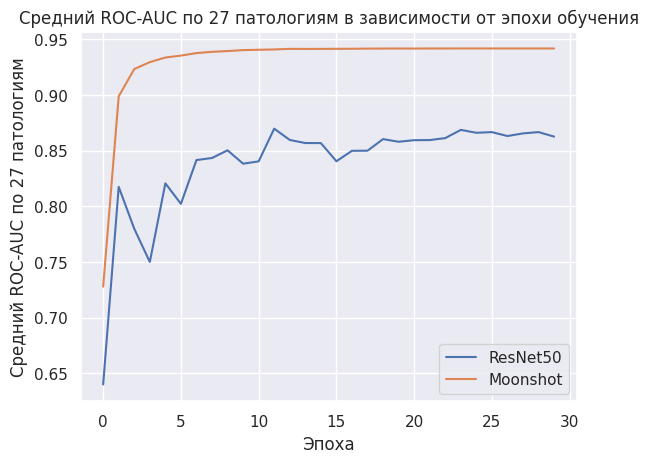

In [23]:
epochs = np.arange(30)

plt.plot(epochs, resnet50_metrics.set_index('epoch')['val/avg_auroc'].dropna().values, label='ResNet50')
plt.plot(epochs, moonshot_metrics.set_index('epoch')['val/avg_auroc'].dropna().values, label='Moonshot')

plt.title("Средний ROC-AUC по 27 патологиям в зависимости от эпохи обучения")
plt.ylabel('Средний ROC-AUC по 27 патологиям')
plt.xlabel('Эпоха')
plt.legend()

Мы видим, что 

* Стандартные классификаторы на основе ResNet50 в среднем достигают ROC-AUC около 0.86.

* Классификаторы на основе Moonshot в среднем достигают ROC-AUC около 0.94, что значительно превосходит качество стандартных классификаторов.

## 5. Заключение

Мы показали пример применения базовой модели Moonshot для обучения классификаторов рентгенографических изображений грудной клетки на выборке VinDR-CXR [1].

Показано, что классификаторы обученные на основе Moonshot значительно превосходят классификаторы, обученные на основе стандартного энкодера ResNet50.

## References

1. Nguyen, H. Q., Lam, K., Le, L. T., Pham, H. H., Tran, D. Q., Nguyen, D. B., ... & Vu, V. (2022). VinDr-CXR: An open dataset of chest X-rays with radiologist’s annotations. Scientific Data, 9(1), 429.